# Introduction

Project này trình bày cách xây dựng phân tích dữ liệu sử dụng Naive Bayes dựa trên reviews on Amazon's product (positive or negative review): http://jmcauley.ucsd.edu/data/amazon/. Trong phạm vi prject này thể loại 'Movies and TV' được sử dụng với database: 'reviews_Movies_and_TV_5.json.gz'


# Exploring data

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [4]:
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


df = getDF('reviews_Movies_and_TV_5.json.gz')

In [5]:
df.head(2)

,reviewText,helpful,overall,reviewTime,reviewerID,asin,summary,reviewerName,unixReviewTime
0,This is a charming version of the classic Dick...,"[0, 0]",4.0,"02 26, 2008",ADZPIG9QOCDG5,0005019281,good version of a classic,"Alice L. Larson ""alice-loves-books""",1203984000
1,It was good but not as emotionally moving as t...,"[0, 0]",3.0,"12 30, 2013",A35947ZP82G7JH,0005019281,Good but not as moving,Amarah Strack,1388361600


In [6]:
df.shape

(1697533, 9)

In [7]:
data = df[['reviewText', 'summary', 'overall']]
data.head(2)

,reviewText,summary,overall
0,This is a charming version of the classic Dick...,good version of a classic,4.0
1,It was good but not as emotionally moving as t...,Good but not as moving,3.0


In [8]:
data.to_csv("reviews_Movies_and_TV_5.csv", index=False, encoding='utf8') #save data to csv for loading later

In [ ]:
data = pd.read_csv('reviews_Movies_and_TV_5.csv')
data.head(2)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697533 entries, 0 to 1697532
Data columns (total 3 columns):
reviewText    object
summary       object
overall       float64
dtypes: float64(1), object(2)
memory usage: 51.8+ MB


# Convert text data to vector and build model

We need to transform the text data to vector data before doing classification. I reference this website http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

# Model 1:
Input: 'reviewText', <br> 
Output: 5 levels: from 1 to 5


In [12]:
train=data.sample(frac=0.7,random_state=200)
test=data.drop(train.index)

In [13]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [14]:
text_clf.fit(train.reviewText, train.overall)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [15]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.53525900326
             precision    recall  f1-score   support

        1.0       0.92      0.00      0.01     31216
        2.0       0.00      0.00      0.00     30655
        3.0       0.48      0.00      0.00     60527
        4.0       0.31      0.01      0.01    114864
        5.0       0.54      1.00      0.70    271998

avg / total       0.47      0.54      0.38    509260

Confusion matrix:
             precision    recall  f1-score   support

       -1.0       0.83      0.00      0.00     61871
        0.0       0.48      0.00      0.00     60527
        1.0       0.76      1.00      0.86    386862

avg / total       0.73      0.76      0.66    509260



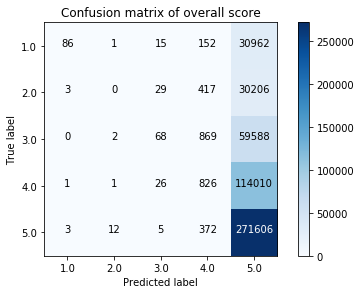

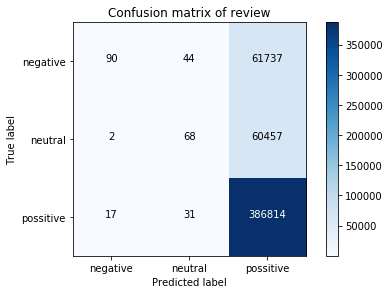

In [16]:
#
predicted = text_clf.predict(test.reviewText)
print(np.mean(predicted == test.overall))
print(metrics.classification_report(test.overall, predicted))

cnf_matrix = metrics.confusion_matrix(test.overall, predicted)
print('Confusion matrix:')
class_names = text_clf.classes_
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of overall score')

#
test['label'] = np.sign(test.overall - 3)
predicted_label = np.sign(predicted - 3)
print(metrics.classification_report(test.label, predicted_label))
# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(test.label, predicted_label)
#

class_names = ['negative', 'neutral', 'possitive']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of review')